In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [2]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_MBLB.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2007-1,969646,2007-01-01
1,2007-2,51237546,2007-02-01
2,2007-3,44745946,2007-03-01
3,2007-4,71632678,2007-04-01
4,2007-5,66687601,2007-05-01


In [4]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/mblb.json', 'w') as f:
    json.dump(json_data, f) 

{"2007-01-01T00:00:00.000":969646,"2007-02-01T00:00:00.000":51237546,"2007-03-01T00:00:00.000":44745946,"2007-04-01T00:00:00.000":71632678,"2007-05-01T00:00:00.000":66687601,"2007-06-01T00:00:00.000":89597411,"2007-07-01T00:00:00.000":65887461,"2007-08-01T00:00:00.000":83654840,"2007-09-01T00:00:00.000":76353701,"2007-10-01T00:00:00.000":80214360,"2007-11-01T00:00:00.000":80922262,"2007-12-01T00:00:00.000":73069860,"2008-01-01T00:00:00.000":106654840,"2008-02-01T00:00:00.000":40048620,"2008-03-01T00:00:00.000":39463500,"2008-04-01T00:00:00.000":77160120,"2008-05-01T00:00:00.000":84685164,"2008-06-01T00:00:00.000":94931221,"2008-07-01T00:00:00.000":141630123,"2008-08-01T00:00:00.000":77472200,"2008-09-01T00:00:00.000":110731300,"2008-10-01T00:00:00.000":129620400,"2008-11-01T00:00:00.000":112973200,"2008-12-01T00:00:00.000":69656400,"2009-01-01T00:00:00.000":180725980,"2009-02-01T00:00:00.000":180175800,"2009-03-01T00:00:00.000":123729800,"2009-04-01T00:00:00.000":103011414,"2009-05-01T

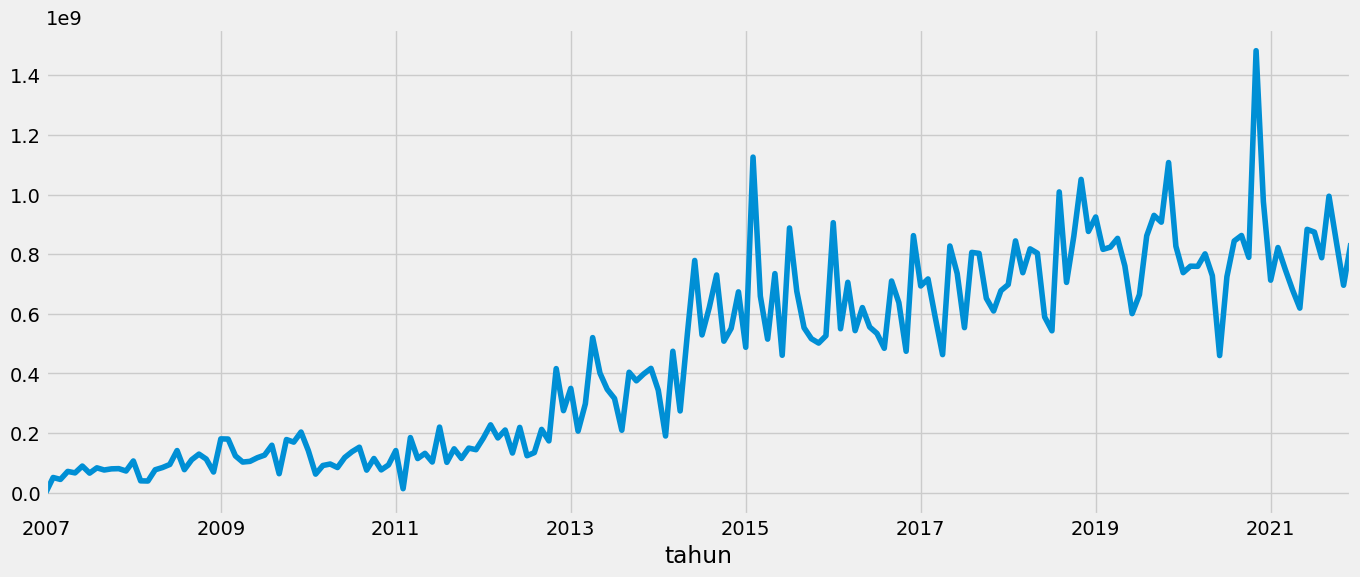

In [20]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [21]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [22]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit()
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
print('\nBest Result:', best_result)


Best Result: [(1, 1, 1), (0, 1, 1, 12), 6777.873368963619]


In [ ]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [5]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(1, 0, 0),seasonal_order=(1, 1, 0, 12),
                            enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -3162.188
Date:                            Wed, 28 Dec 2022   AIC                           6330.376
Time:                                    08:07:52   BIC                           6339.506
Sample:                                01-01-2007   HQIC                          6334.084
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3725      0.093      3.995      0.000       0.190       0.555
ar.S.L12      -0.4664      0.074   

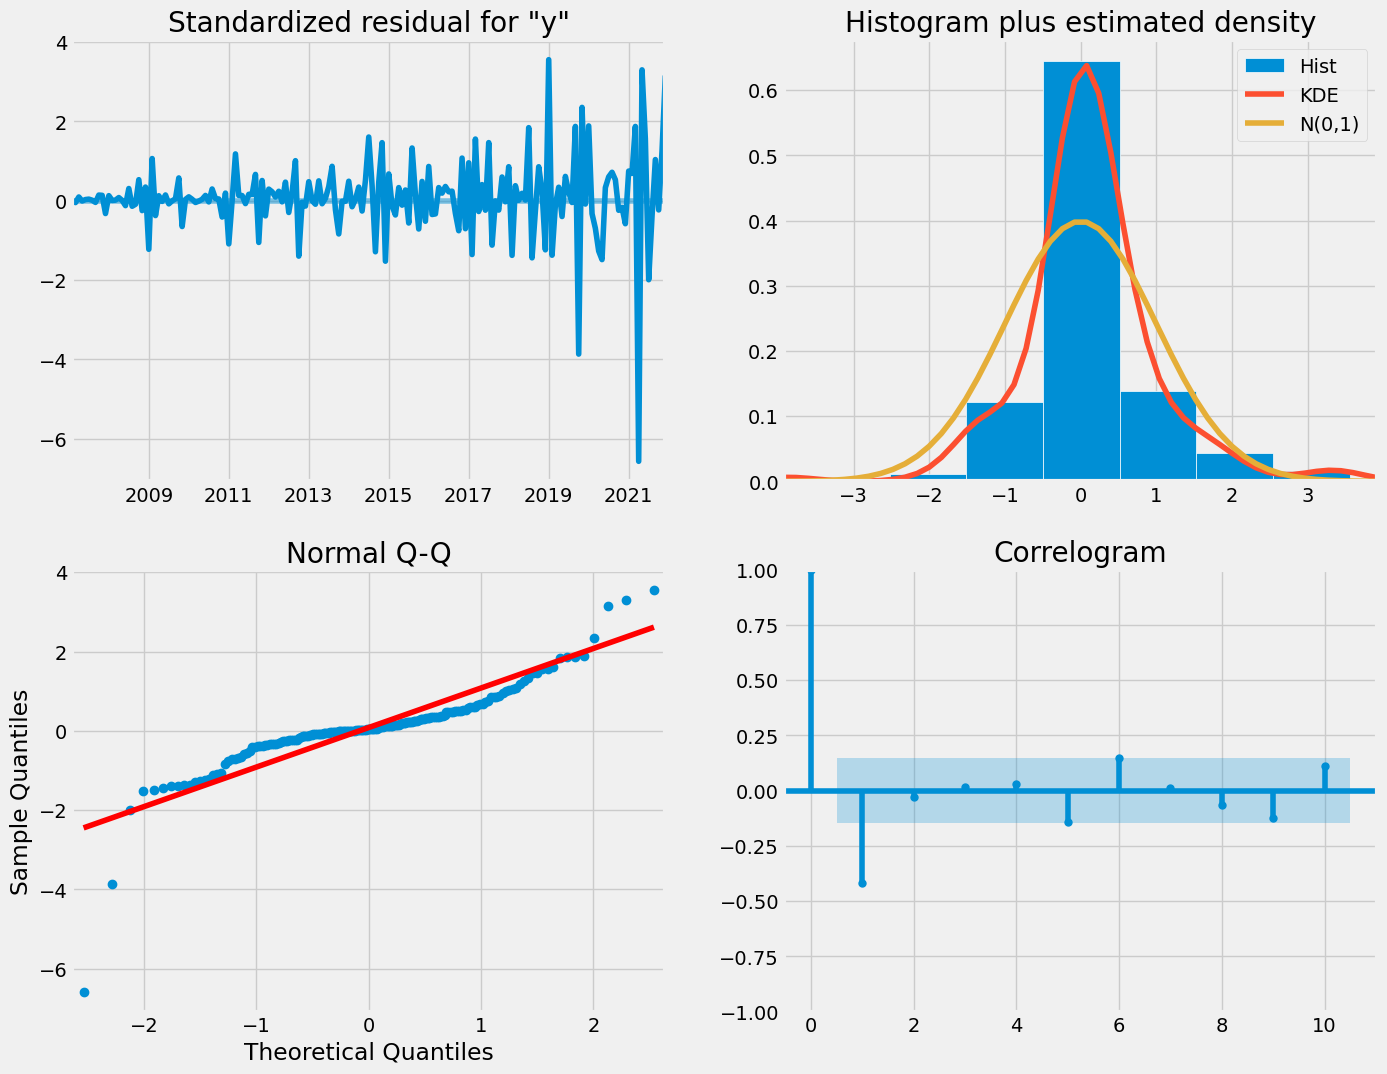

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

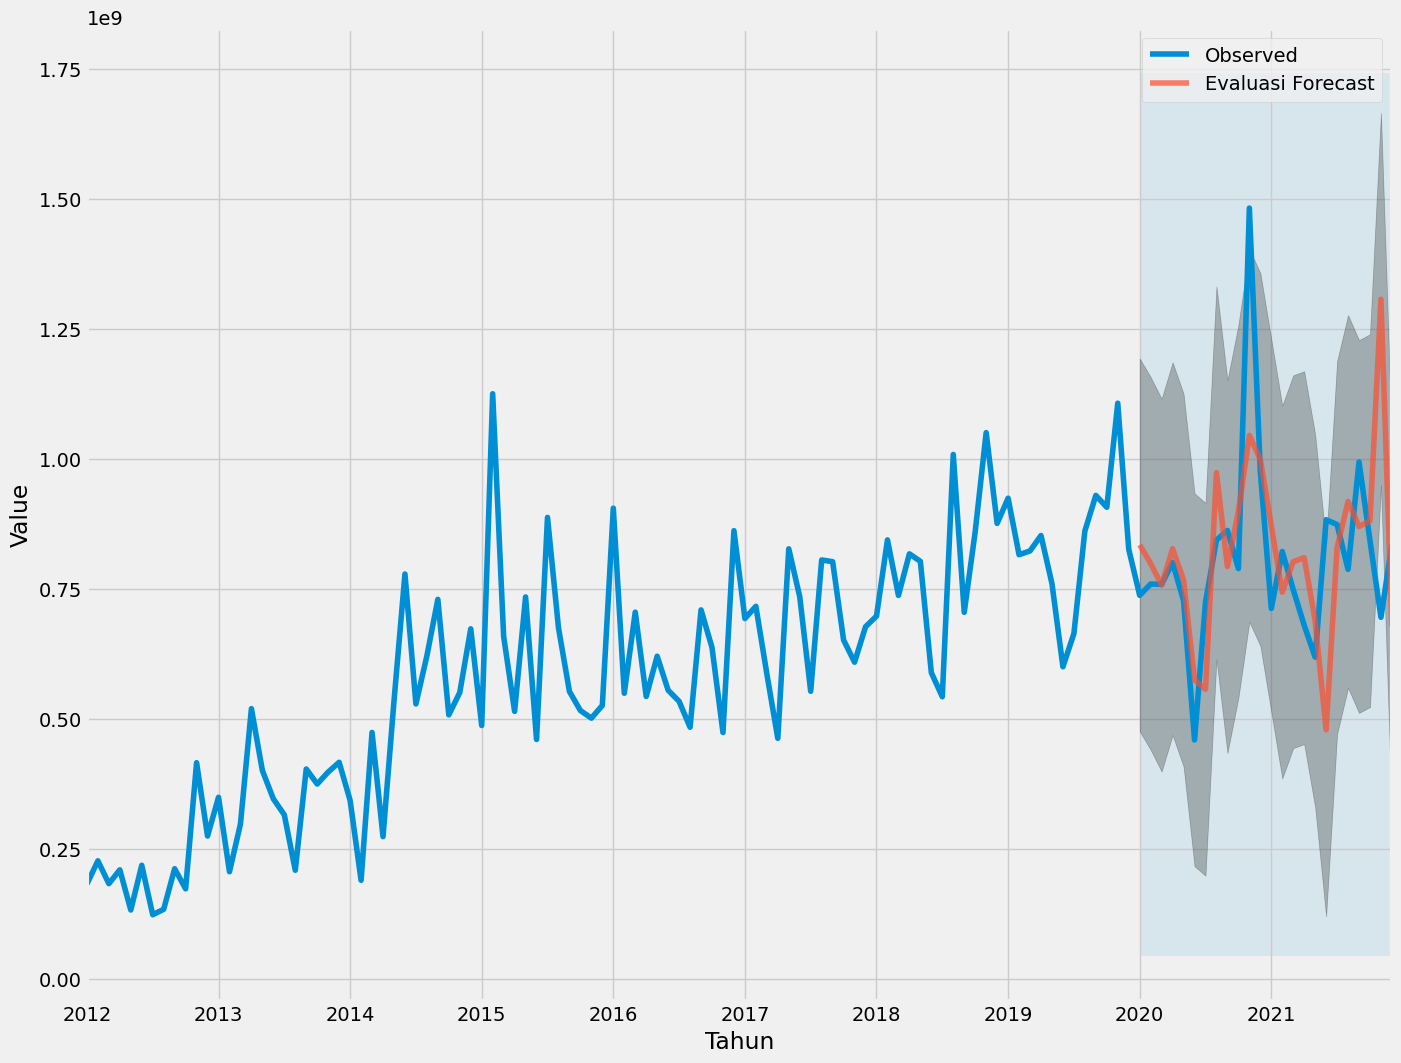

In [37]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

# Prediksi data selama 2 tahun

In [8]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=60, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()


json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/mblb_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":698462779.6215524673,"2022-02-01T00:00:00.000":783329823.1099823713,"2022-03-01T00:00:00.000":750119091.8903326988,"2022-04-01T00:00:00.000":735319981.2762906551,"2022-05-01T00:00:00.000":669270563.1928772926,"2022-06-01T00:00:00.000":685681681.6198267937,"2022-07-01T00:00:00.000":804206978.6684527397,"2022-08-01T00:00:00.000":814152854.7298823595,"2022-09-01T00:00:00.000":932868287.7440558672,"2022-10-01T00:00:00.000":817985285.5591195822,"2022-11-01T00:00:00.000":1062540644.8649382591,"2022-12-01T00:00:00.000":901623031.3168200254,"2023-01-01T00:00:00.000":705106680.8667123318,"2023-02-01T00:00:00.000":801437323.9234720469,"2023-03-01T00:00:00.000":749590057.0628553629,"2023-04-01T00:00:00.000":709702984.834141016,"2023-05-01T00:00:00.000":645869206.4957329035,"2023-06-01T00:00:00.000":777800509.9756066799,"2023-07-01T00:00:00.000":836757035.5485758781,"2023-08-01T00:00:00.000":801941938.1582510471,"2023-09-01T00:00:00.000":961515788.2679817677,"2023-10-01T

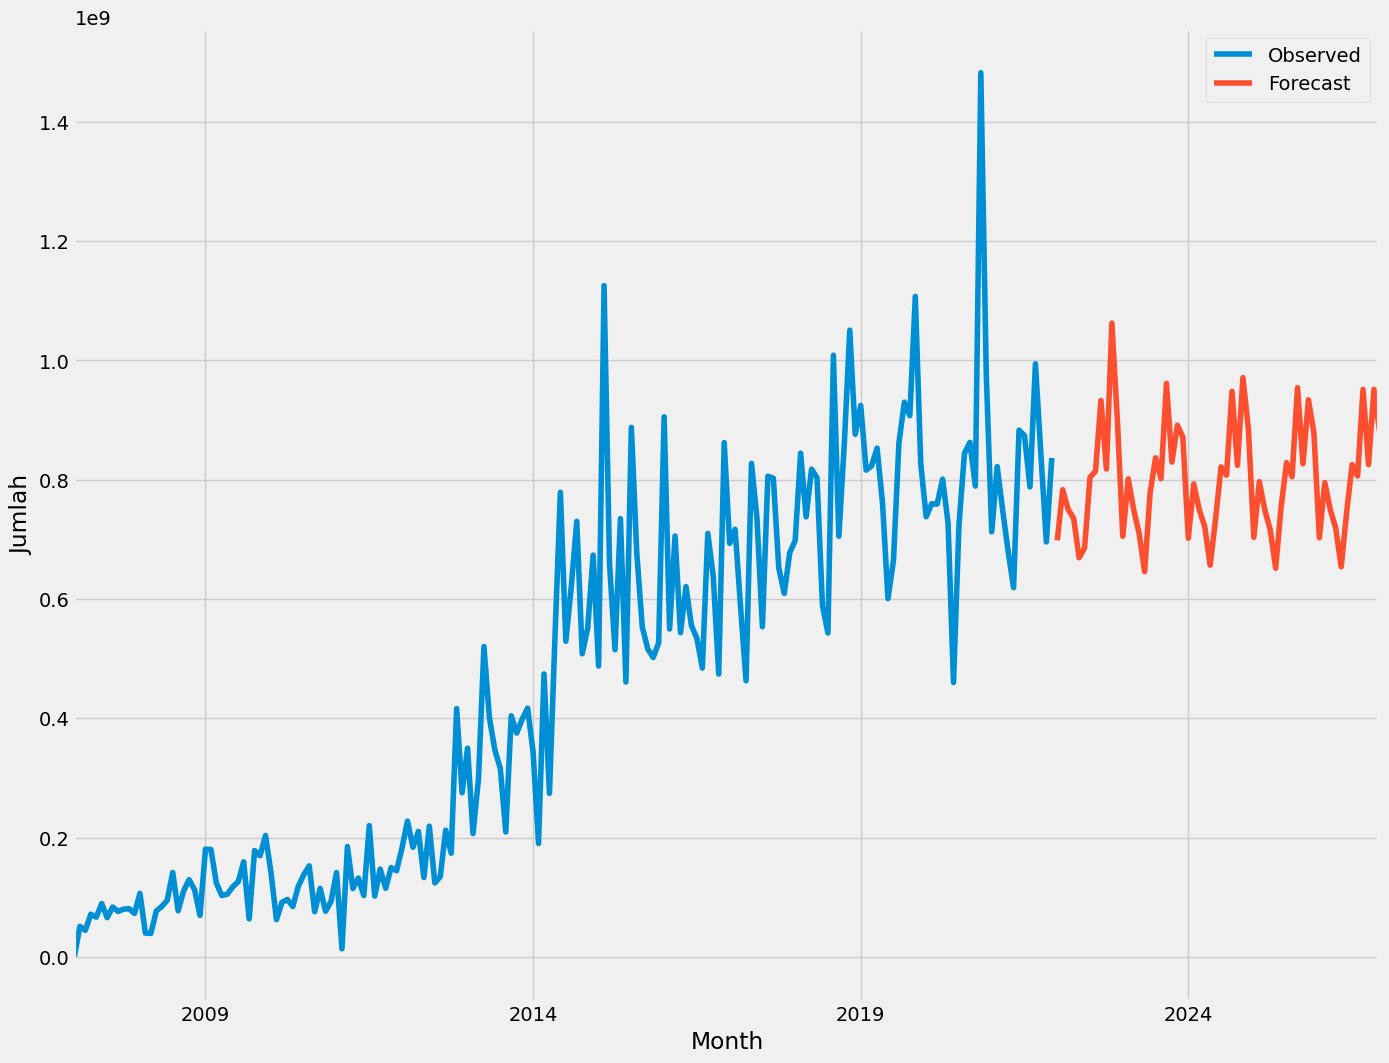

In [9]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()